## Assignment 02 - Logistic Regression Classifier using PyTorch on CIFAR-10 Dataset

#### Submitted By:
1. Dhruvan Ganesh
2. Sheikh Mastura Farzana


### Imports

In [0]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn import preprocessing
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

### Environment Information

In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = "~/.datasets"
seed = 42

random_seed(seed, torch.cuda.is_available())

print("Device:", device)
if torch.cuda.is_available():
  print("Device Name:", torch.cuda.get_device_name(0))
print("Data Dir:", data_dir)
print("Set Random Seed:", seed)

Device: cuda:0
Device Name: Tesla P100-PCIE-16GB
Data Dir: ~/.datasets
Set Random Seed: 42


In [0]:
## Plotting Utils


def plotLine(arr: [], title=""):
    plt.plot(np.squeeze([range(1, len(arr) + 1)]), np.squeeze(arr))
    plt.title(title)
    plt.show()


def plotLines(arr: [], arr2: [], title="", labels=[]):
    plt.plot(np.squeeze([range(1, len(arr) + 1)]), np.squeeze(arr), label=labels[0])
    plt.plot(np.squeeze([range(1, len(arr2) + 1)]), np.squeeze(arr2), label=labels[1])
    plt.title(title)
    plt.legend()
    plt.show()


def plotNumpyArray(ndarray, title="", xlabel=""):
    df = pd.DataFrame(
        ndarray, columns=[f"Param {i}" for i in range(1, ndarray.shape[1] + 1)]
    )
    df.plot.line()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

### Class to load CIFAR10

In [0]:
class CIFAR10Data:
    def __init__(self):
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        self.trainset = datasets.CIFAR10(
            root=data_dir, train=True, download=True, transform=transform
        )
        self.testset = datasets.CIFAR10(
            root=data_dir, train=False, download=True, transform=transform
        )

        self.classes = (
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        )

    def get_cifar10_data(self):
        return self.trainset, self.testset, self.classes

    def get_cifar10_batch_loaders(self, batch_size=64):

        train_dataloader = DataLoader(
            self.trainset,
            shuffle=True,
            batch_size=batch_size,
            drop_last=True,
            num_workers=4,
        )
        test_dataloader = DataLoader(
            self.testset,
            shuffle=False,
            batch_size=batch_size,
            drop_last=True,
            num_workers=4,
        )

        return train_dataloader, test_dataloader


### Model Trainer Class

In [0]:
class Trainer(object):
    """
    The Trainer class,
    which makes use of Torch's Module, Loss, Optimizer implementations
    """

    def __init__(
        self,
        model: nn.Module,
        loss: nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer,
    ):
        self._model = model
        self._loss = loss
        self._optimizer = optimizer

    def __str__(self):
        return f"""Trainer:\nArch:\n{self._model}\nLoss: {self._loss}"""

    def predict_classes(self, dataloader, retLabels=False):
        predY: [int] = []
        actualY: [int] = []
        for X, Y in dataloader:
            X, Y = X.to(device), Y
            X = X.reshape(dataloader.batch_size, -1).to(device)
            class_probabilities = self._model(X)
            class_predictions = torch.argmax(class_probabilities, dim=1)
            predY.extend(class_predictions.tolist())
            actualY.extend(Y.tolist())
        if retLabels:
            return predY, actualY
        else:
            return predY

    def fit(
        self,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        epochs=100,
        track_metrics=True,
        log=True,
        log_interval=10,
        plot_learning_curve=True,
        plot_gradient_norm=True,
    ):
        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        grad_norms = []

        for epoch in range(1, epochs + 1):
            self._model.train()
            train_loss = 0.0
            train_acc = 0.0
            grad_norm = []
            for batch_id, (X, Y) in enumerate(train_dataloader):
                X, Y = X.to(device), Y.to(device)
                X = X.view(train_dataloader.batch_size, -1).to(device)
                self._optimizer.zero_grad()
                class_probabilities = self._model(X)
                loss = self._loss(class_probabilities, Y)

                if track_metrics:
                    train_loss += loss.item()
                    class_prediction = torch.argmax(class_probabilities, dim=1)
                    train_acc += (class_prediction == Y.data).sum().item()

                loss.backward()

                if plot_gradient_norm:
                    grads = torch.Tensor(
                        [
                            p.grad.data.norm(2).cpu()
                            for p in list(
                                filter(
                                    lambda p: p.grad is not None,
                                    self._model.parameters(),
                                )
                            )
                        ]
                    ).to(device)
                    grad_norm.append(grads)

                self._optimizer.step()

            if track_metrics:
                train_losses.append(train_loss)
                train_acc /= len(train_dataloader.dataset)
                train_accs.append(train_acc)

            test_loss, test_acc = self.validation(test_dataloader)
            test_accs.append(test_acc)
            if log and epoch % log_interval == 0:
                test_losses.append(test_loss)
                print(
                    "Epoch: {}\tTraining Loss: {:.4f}\tTraining Acc: {:.4f}\tTest Acc: {:.4f}\t".format(
                        epoch, train_loss, train_acc, test_acc
                    )
                )

            if plot_gradient_norm:
                grad_norm = torch.stack(grad_norm)
                grad_norm_parameters = torch.sqrt(torch.sum(grad_norm, 0))
                grad_norms.append(grad_norm_parameters)

        if plot_learning_curve:
            plotLine(train_losses, title="Training Loss")
            plotLine(test_losses, title="Test Loss")
            plotLines(train_accs, test_accs, title="Accuracy", labels=["train", "test"])

        if plot_gradient_norm:
            grad_norms = torch.stack(grad_norms).cpu().numpy()
            grad_norms = grad_norms.reshape(epochs, -1)
            plotNumpyArray(
                grad_norms,
                title="Gradient Norms of The Learnable Parameters",
                xlabel="Epochs",
            )

            min_max_scaler = preprocessing.MinMaxScaler()
            grad_norms_scaled = min_max_scaler.fit_transform(grad_norms)
            plotNumpyArray(
                grad_norms_scaled,
                title="Scaled Gradient Norms of The Learnable Parameters",
                xlabel="Epochs",
            )

        return train_accs, test_accs

    def validation(self, testloader):
        test_loss = 0
        accuracy = 0

        for testX, testY in testloader:
            testX, testY = testX.to(device), testY.to(device)
            testX = testX.reshape(testloader.batch_size, -1).to(device)

            predictions = self._model(testX)
            test_loss += self._loss(predictions, testY).item()

            argmax = torch.argmax(predictions, dim=1)
            accuracy += (argmax == testY.data).sum().item()

        return test_loss, accuracy / len(testloader.dataset)

### Initialize custom Trainer class with a Model, Loss Function and Optimizer

In [7]:
cifar10_data = CIFAR10Data()


def run_model_trainer(learning_rate, batch_size, print_trainer_info=False, **kwargs):

    _model = nn.Sequential(
        nn.Linear(1024 * 3, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.Softmax(-1),
    )

    _trainer = Trainer(
        model=_model.to(device),
        loss=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(_model.parameters(), lr=learning_rate),
    )

    if print_trainer_info:
        print(_trainer)

    _train_dataloader, _test_dataloader = cifar10_data.get_cifar10_batch_loaders(
        batch_size=batch_size
    )

    _train_accs, _test_accs = _trainer.fit(
        _train_dataloader, _test_dataloader, **kwargs
    )

    return _trainer, (_train_dataloader, _test_dataloader), (_train_accs, _test_accs)

Extracting /root/.datasets/cifar-10-python.tar.gz to /root/.datasets
Files already downloaded and verified


### Train the model on CIFAR10

Trainer:
Arch:
Sequential(
  (0): Linear(in_features=3072, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=-1)
)
Loss: CrossEntropyLoss()
Epoch: 10	Training Loss: 1508.5943	Training Acc: 0.5268	Test Acc: 0.4804	
Epoch: 20	Training Loss: 1478.3267	Training Acc: 0.5661	Test Acc: 0.5026	
Epoch: 30	Training Loss: 1461.0079	Training Acc: 0.5886	Test Acc: 0.4981	
Epoch: 40	Training Loss: 1452.2051	Training Acc: 0.6002	Test Acc: 0.4926	
Epoch: 50	Training Loss: 1446.7737	Training Acc: 0.6070	Test Acc: 0.5009	
Epoch: 60	Training Loss: 1444.4113	Training Acc: 0.6108	Test Acc: 0.4987	
Epoch: 70	Training Loss: 1443.4247	Training Acc: 0.6122	Test Acc: 0.4963	
Epoch: 80	Training Loss: 1444.5532	Training Acc: 0.6109	Test Acc: 0.5042	
Epoch: 90	Training Loss: 1450.7350	Training Acc: 0.6028	Test Acc: 0.4865	
Epoch: 100	Training Loss: 1456.1553	Training Acc: 0

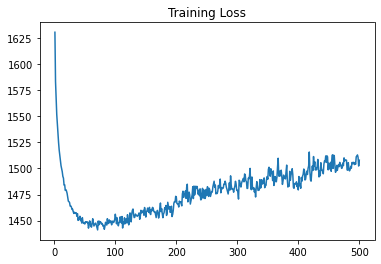

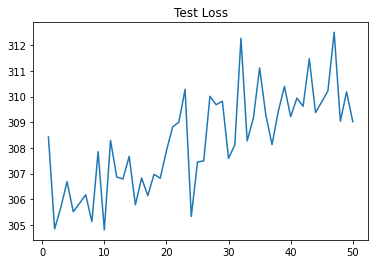

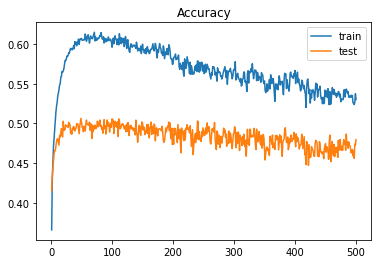

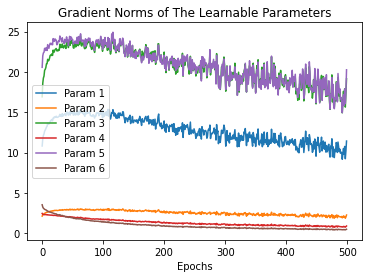

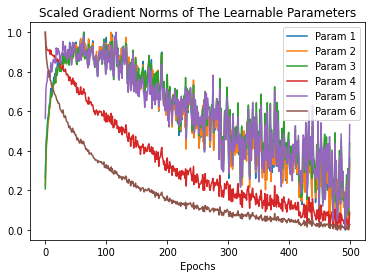

In [8]:
trainer, (train_dataloader, test_dataloader), _ = run_model_trainer(
    batch_size=64,
    learning_rate=1e-3,
    print_trainer_info=True,
    epochs=500
)


### Plot Confusion Matrix

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(predicted, actual, title=""):
    cf_matrix = confusion_matrix(predicted, actual)
    cf_matrix = cf_matrix.astype("float") / cf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    plt.title(title)
    plt.ylabel("Predicted Label")
    plt.xlabel("Actual Label")
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


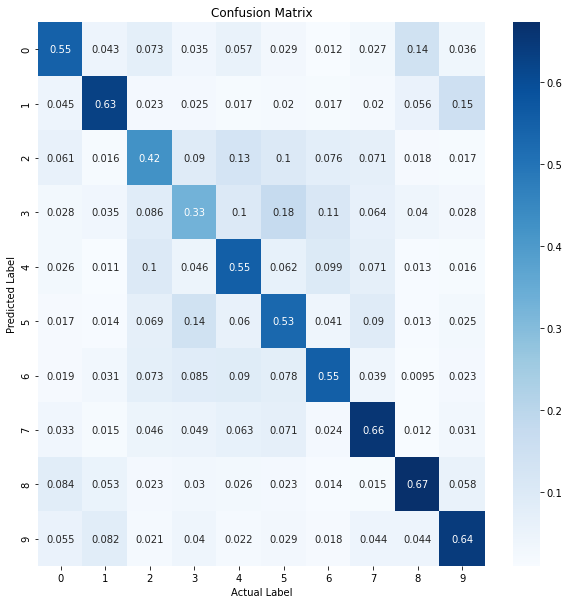

In [10]:
cfPredictedY, cfActualY = trainer.predict_classes(train_dataloader, True)

plot_confusion_matrix(cfPredictedY, cfActualY, title="Confusion Matrix")

### HyperOpt: do random search to select the best parameters (objective: maximize F1 Score)

In [11]:
import hyperopt
from hyperopt import hp, fmin, tpe
from sklearn.metrics import f1_score


def tune_learning_rate(search_space_n_times, max_train_epochs):
    def objective(args):
        print("Evaluating Config: ", args)

        _trainer, (_, _test_dataloader), (_train_acc, _test_acc) = run_model_trainer(
            **args,
            epochs=max_train_epochs,
            track_metrics=False,
            log=False,
            plot_learning_curve=False,
            plot_gradient_norm=False,
        )

        _predicted_labels, _actual_labels = _trainer.predict_classes(_test_dataloader, True)
        score = f1_score(_actual_labels, _predicted_labels, average='weighted')
        print(f"F1 Score: {score}")

        # maximize F1 score
        return -score

    space = {
        "batch_size": hp.choice("batch_size", [32, 64, 128, 256]),
        "learning_rate": hp.loguniform("learning_rate", np.log(1e-4), np.log(0.01)),
    }

    best = fmin(objective, space, algo=tpe.suggest, max_evals=search_space_n_times)

    return hyperopt.space_eval(space, best)


best_params = tune_learning_rate(search_space_n_times=20, max_train_epochs=100)
print("Best Parameters: ", best_params)

Evaluating Config: 
{'batch_size': 32, 'learning_rate': 0.00010459587158232298}
F1 Score: 0.5070012311472534
Evaluating Config: 
{'batch_size': 32, 'learning_rate': 0.004771770984946724}
F1 Score: 0.018202683430336396
Evaluating Config: 
{'batch_size': 32, 'learning_rate': 0.0005753046150316646}
F1 Score: 0.5188595036536731
Evaluating Config: 
{'batch_size': 64, 'learning_rate': 0.0019635030299510535}
F1 Score: 0.32430953823567116
Evaluating Config: 
{'batch_size': 32, 'learning_rate': 0.0065300146268399886}
F1 Score: 0.018202683430336396
Evaluating Config: 
{'batch_size': 64, 'learning_rate': 0.00213178847012458}
F1 Score: 0.3068839824599605
Evaluating Config: 
{'batch_size': 256, 'learning_rate': 0.002503211256471832}
F1 Score: 0.45592597771825283
Evaluating Config: 
{'batch_size': 128, 'learning_rate': 0.0008712131745190458}
F1 Score: 0.5193984956396803
Evaluating Config: 
{'batch_size': 256, 'learning_rate': 0.0024662039295627446}
F1 Score: 0.45548628429232696
Evaluating Config: 
{

### HyperOpt: Train with the Best Parameters

Epoch: 10	Training Loss: 741.7094	Training Acc: 0.5575	Test Acc: 0.4945	
Epoch: 20	Training Loss: 717.2673	Training Acc: 0.6209	Test Acc: 0.5140	
Epoch: 30	Training Loss: 703.1977	Training Acc: 0.6572	Test Acc: 0.5168	
Epoch: 40	Training Loss: 695.7039	Training Acc: 0.6759	Test Acc: 0.5204	
Epoch: 50	Training Loss: 688.1422	Training Acc: 0.6955	Test Acc: 0.5166	
Epoch: 60	Training Loss: 683.0946	Training Acc: 0.7084	Test Acc: 0.5206	
Epoch: 70	Training Loss: 679.8294	Training Acc: 0.7168	Test Acc: 0.5184	
Epoch: 80	Training Loss: 676.9134	Training Acc: 0.7242	Test Acc: 0.5169	
Epoch: 90	Training Loss: 675.7000	Training Acc: 0.7271	Test Acc: 0.5243	
Epoch: 100	Training Loss: 673.7341	Training Acc: 0.7323	Test Acc: 0.5174	
Epoch: 110	Training Loss: 673.9519	Training Acc: 0.7315	Test Acc: 0.5186	
Epoch: 120	Training Loss: 673.4385	Training Acc: 0.7330	Test Acc: 0.5203	
Epoch: 130	Training Loss: 671.9175	Training Acc: 0.7364	Test Acc: 0.5150	
Epoch: 140	Training Loss: 669.3839	Training Acc

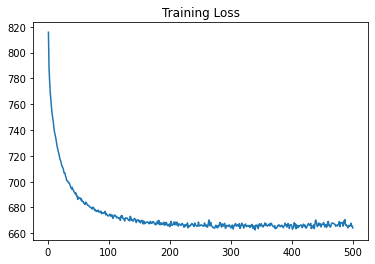

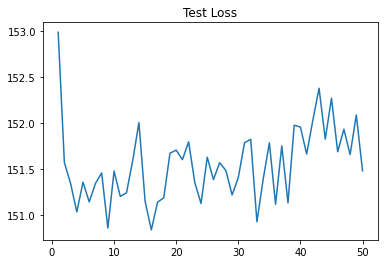

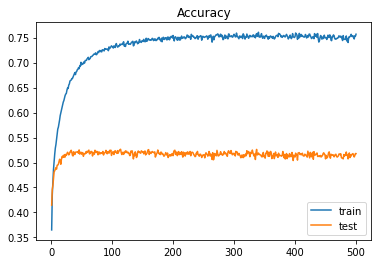

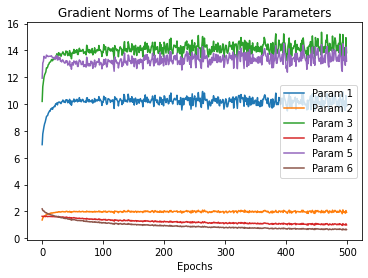

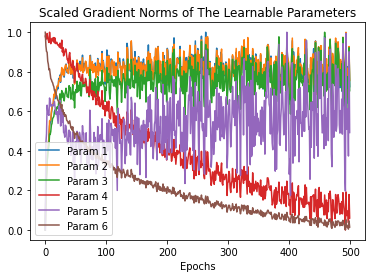

In [12]:
trainer, (train_dataloader, _), _ = run_model_trainer(
    **best_params,
    epochs=500
)